In [1]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, draw_density_ratio_GP, refine_sample_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2

In [104]:
dataset = ToyGraspDataset(root='data', size=1200)
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks
handle_masks = data[:,3] == 1

In [105]:
# load pos vs neg classifier
f = ClassifierNN([2, 64, 64, 1])
f, info = load_model_info('pos_vs_neg', f)
f = f.to(device)

0.0 0.99972206


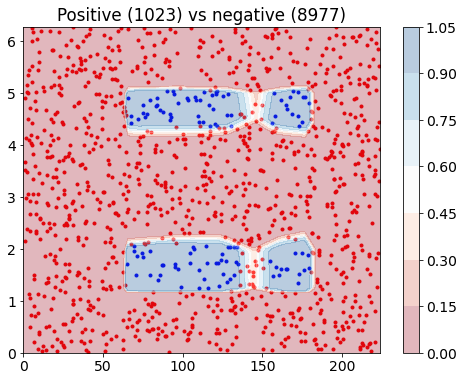

In [106]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)

ax.set_title(f'Positive ({int(info["pos_samples_size"])}) vs negative ({int(info["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

-8.188068 246.96236


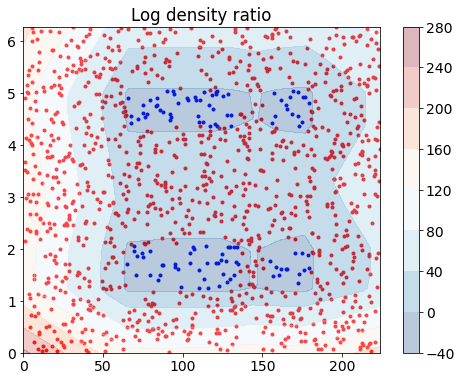

In [107]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05)

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [108]:
# refine samples
my_sample = torch.FloatTensor([[25, 0.3],
                               [210, 3]])#[160, 3]
my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

In [109]:
steps_refinement = 100
all_x1, all_v1 = refine_sample(my_sample.to(device), f, steps=steps_refinement,
                               eta=0.00001, noise_factor=0.001,
                              Nq = info['pos_samples_size'], Np = info['neg_samples_size'])

  0%|          | 0/100 [00:00<?, ?it/s]

-0.933095 28.143309


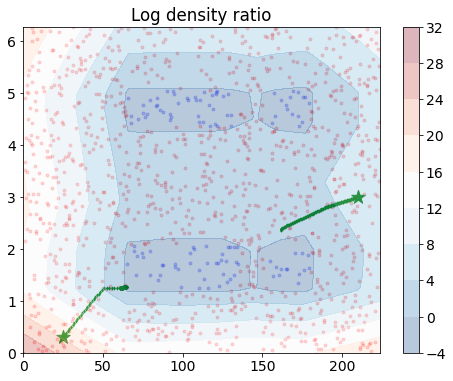

In [110]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)

Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                      Np=info['neg_samples_size'], Nq=info['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Real+ vs Sim+

In [388]:
dataset = ToyGraspDataset(root='data', name='sim2real_train', size=500, is_pos_label=True, device=device)
corr_data = dataset.data
c_pos_masks = corr_data[:,2] == 1
c_neg_masks = ~c_pos_masks


sim2real!!!


In [446]:
# load sim+ vs sim- classifier
f2 = ClassifierNN([2, 32, 32, 1])
f2, info2 = load_model_info('sim_vs_real_1k', f2)
f2 = f2.to(device)

0.0 1.0


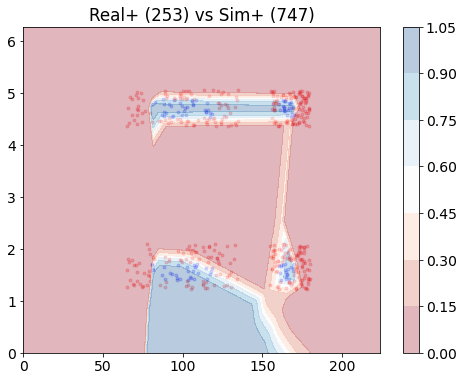

In [447]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)




ax.set_title(f'Real+ ({int(info2["pos_samples_size"])}) vs Sim+ ({int(info2["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [391]:
steps_refinement = 100
all_x1, all_v1 = refine_sample(my_sample.to(device), f2, steps=steps_refinement,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = info2['pos_samples_size'], Np = info2['neg_samples_size'])

  0%|          | 0/100 [00:00<?, ?it/s]

-1.0136011 61.598557


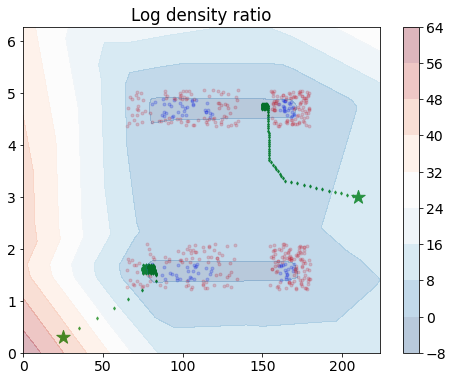

In [392]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)


Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np=info2['neg_samples_size'], Nq=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Multiple classifiers

In [116]:
steps_refinement = 50
all_x8, all_v8 = refine_sample2(my_sample.to(device), f, f2,
                                steps=steps_refinement,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
all_x8 = torch.cat(all_x8).numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

In [117]:
# Np1=info['neg_samples_size'],
#                                 Nq1=info['pos_samples_size'],
#                                 Np2=info2['neg_samples_size'],
#                                 Nq2=info2['pos_samples_size']

-10.743687 84629.36


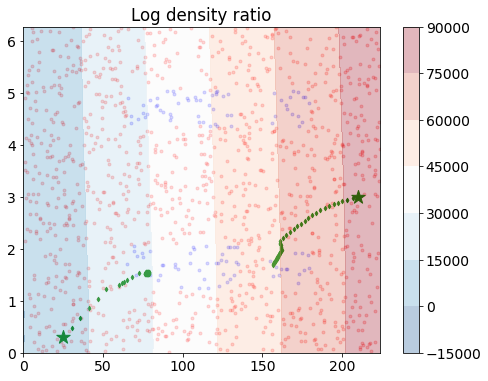

In [118]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# for i in range(1, steps_refinement, 1):
plt.scatter(all_x8[:,0]*224, all_x8[:,1]*(2*3.14), marker='d', color='g', s=10)

Z, CS = draw_density_ratio2(ax=ax,
                   model1=f,
                   model2=f2,
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np1=info['neg_samples_size'],
                   Nq1=info['pos_samples_size'],
                   Np2=info2['neg_samples_size'],
                   Nq2=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# GP Classifier Sim+ vs Real+

In [5]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)


sim2real!!!


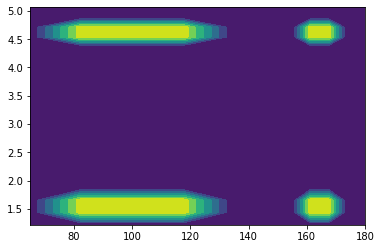

In [87]:
# USING 2D FORK DATA ===============================

n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=1000, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long()
x_t = train_x.clone()
# Normalize inputs
x_t[:,0] /= 244
x_t[:,1] /= (3.14*2)

y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_y = torch.Tensor(test_dataset.data[:,2]).long()
test_labels = torch.reshape(test_y, (n, n))


plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

pos_masks = train_y == 1
neg_masks = ~pos_masks

In [88]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel



# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )
        
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=False) 
model = DirichletGPModel(x_t, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = likelihood(model(x_t))
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
#     loss = -mll(output, train_y).sum()

    loss.backward()
    if i % 10 == 0:
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item()
#             model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/100 - Loss: 4.829   lengthscale: 0.693
Iter 11/100 - Loss: 4.789   lengthscale: 0.609
Iter 21/100 - Loss: 4.561   lengthscale: 0.689
Iter 31/100 - Loss: 4.047   lengthscale: 0.826
Iter 41/100 - Loss: 3.995   lengthscale: 0.939
Iter 51/100 - Loss: 4.004   lengthscale: 1.001
Iter 61/100 - Loss: 3.984   lengthscale: 1.030
Iter 71/100 - Loss: 3.985   lengthscale: 1.041
Iter 81/100 - Loss: 3.981   lengthscale: 1.044
Iter 91/100 - Loss: 3.988   lengthscale: 1.044


In [94]:
steps_refinement = 10


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
my_sample = torch.FloatTensor([[25, 0.3],
# my_sample = torch.FloatTensor([[100, 1.5]])
# my_sample = torch.FloatTensor([[100, 2],
                               [210, 3]])#[160, 3]

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)


model.to(device)
model.eval()
likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
#                                eta=0.1, noise_factor=0.000,
                               eta=10, noise_factor=0.000,
                              Nq = Nq, Np = Np)

229 771


  0%|          | 0/10 [00:00<?, ?it/s]

grad: tensor([[ 0.0033, -0.0017],
        [ 0.0027, -0.0022]], device='cuda:0')
_velocity: tensor([[ 0.0033, -0.0017],
        [ 0.0027, -0.0022]], device='cuda:0')
grad: tensor([[ 0.0033, -0.0017],
        [ 0.0027, -0.0022]], device='cuda:0')
grad: tensor([[ 0.0033, -0.0017],
        [ 0.0026, -0.0021]], device='cuda:0')
_velocity: tensor([[ 0.0033, -0.0017],
        [ 0.0026, -0.0021]], device='cuda:0')
grad: tensor([[ 0.0033, -0.0017],
        [ 0.0026, -0.0021]], device='cuda:0')
grad: tensor([[ 0.0033, -0.0017],
        [ 0.0026, -0.0021]], device='cuda:0')
_velocity: tensor([[ 0.0033, -0.0017],
        [ 0.0026, -0.0021]], device='cuda:0')
grad: tensor([[ 0.0033, -0.0017],
        [ 0.0026, -0.0021]], device='cuda:0')
grad: tensor([[ 0.0033, -0.0017],
        [ 0.0025, -0.0021]], device='cuda:0')
_velocity: tensor([[ 0.0033, -0.0017],
        [ 0.0025, -0.0021]], device='cuda:0')
grad: tensor([[ 0.0033, -0.0017],
        [ 0.0025, -0.0021]], device='cuda:0')
grad: tensor([[ 0.00

In [90]:
# train_x
all_x1

[tensor([[0.1116, 0.0478],
         [0.9375, 0.4777]]),
 tensor([[0.1119, 0.0476],
         [0.9378, 0.4775]]),
 tensor([[0.1123, 0.0474],
         [0.9380, 0.4773]]),
 tensor([[0.1126, 0.0473],
         [0.9383, 0.4771]]),
 tensor([[0.1129, 0.0471],
         [0.9386, 0.4768]]),
 tensor([[0.1132, 0.0469],
         [0.9388, 0.4766]]),
 tensor([[0.1136, 0.0467],
         [0.9391, 0.4764]]),
 tensor([[0.1139, 0.0466],
         [0.9394, 0.4762]]),
 tensor([[0.1142, 0.0464],
         [0.9396, 0.4760]]),
 tensor([[0.1146, 0.0462],
         [0.9399, 0.4758]]),
 tensor([[0.1149, 0.0460],
         [0.9402, 0.4755]])]

  0%|          | 0/10 [00:00<?, ?it/s]

0.0 1.0


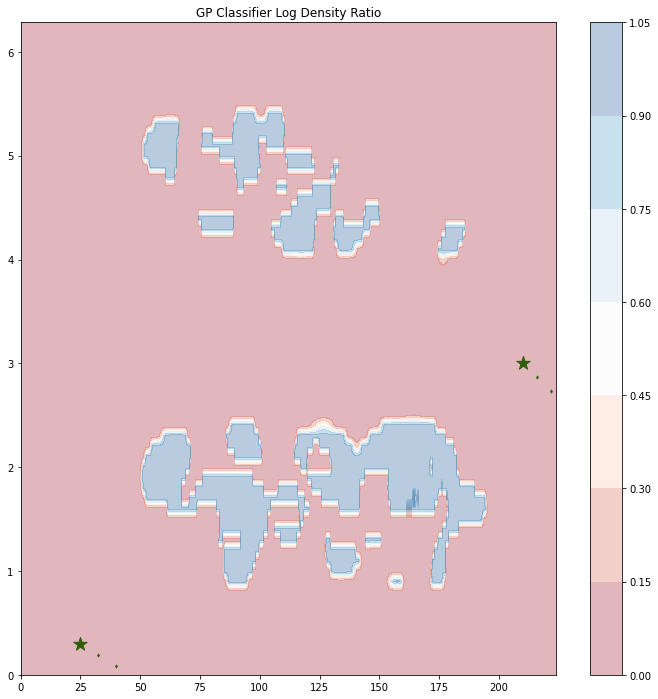

In [95]:
import torch
torch.cuda.empty_cache()
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
# ax.scatter(train_x[pos_masks][:,0], train_x[pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(train_x[neg_masks][:,0], train_x[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)


Z, CS = draw_density_ratio_GP(ax=ax,
                   model=model,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

-3221.75 7212.1626


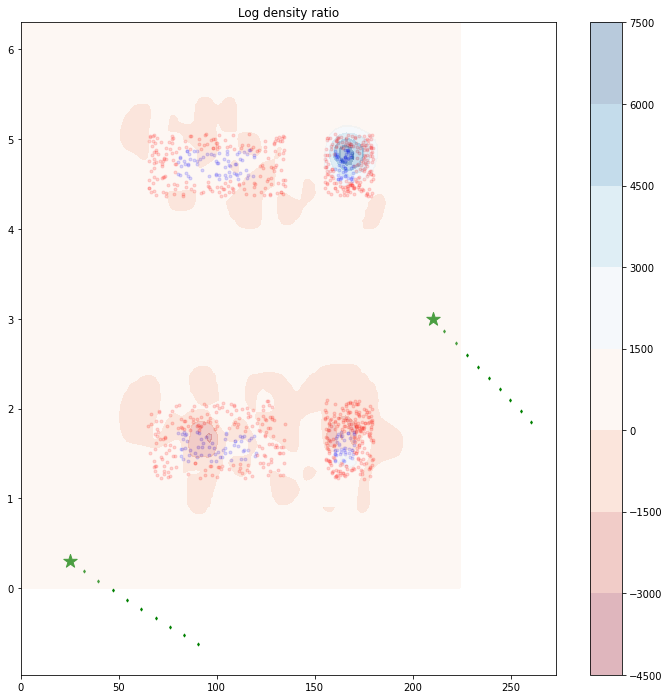

In [96]:
import torch
torch.cuda.empty_cache()
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0], train_x[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_masks][:,0], train_x[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)


Z, CS = draw_density_ratio_GP(ax=ax,
                   model=model,
                   likelihood=likelihood,
#                    p_type='p_y_given_x',
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'Log density ratio')
# ax.set_xlim([0, 224])
# ax.set_ylim([0, 2*np.pi])

plt.show()

# Refining Multiple Grasps

1. Create test dataset
2. Refine datapoints
    - using single refinement
    - using corrector refinement
3. create graph/table

real_refine!!


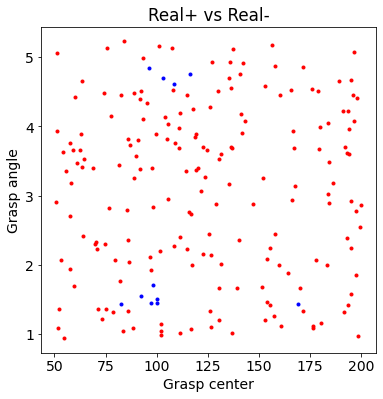

In [401]:
from dataset import ToyGraspDataset
# real_dataset = ToyGraspDataset(root='data', size=10000, is_pos_label=True, device=device)
real_dataset = ToyGraspDataset(root='data', name='real_refine', size=200, is_pos_label=True, device=device)

# show the data
real_data = real_dataset.data
real_pos_masks = real_data[:,2] == 1
real_neg_masks = ~real_pos_masks


fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(real_data[real_pos_masks][:,0], real_data[real_pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(real_data[real_neg_masks][:,0], real_data[real_neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Real+ vs Real-')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

real_data = torch.tensor(real_data[:,:2])
real_data[:,0] /= 224
real_data[:,1] /= (2*3.14)

In [421]:
# load pos vs neg classifier
f = ClassifierNN([2, 64, 64, 1])
f, info = load_model_info('pos_vs_neg', f)
f = f.to(device)

In [458]:
# load sim+ vs sim- classifier
f2 = ClassifierNN([2, 32, 32, 1])
f2, info2 = load_model_info('sim_vs_real_5k', f2)
# f2, info2 = load_model_info('sim_vs_real_2.5k', f2)
# f2, info2 = load_model_info('sim_vs_real_1k', f2)
f2 = f2.to(device)

In [459]:
# set refinement parameters
f_div = 'JS'
steps_refinement = 100

In [460]:
all_x1, all_v1 = refine_sample(real_data.to(device), f, steps=steps_refinement, f=f_div,
                               eta=0.00001, noise_factor=0.001,
                              Nq = info['pos_samples_size'], Np = info['neg_samples_size'])

refined_points = all_x1[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_orig_pos = np.sum(real_pos_masks)
n_refined_pos = count_real_positives(refined_points)

print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

11
32


In [461]:
all_x2, all_v2 = refine_sample(real_data.to(device), f2, steps=steps_refinement, f=f_div,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = info2['pos_samples_size'], Np = info2['neg_samples_size'])
refined_points = all_x2[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_orig_pos = np.sum(real_pos_masks)
n_refined_pos = count_real_positives(refined_points)

print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

11
31


In [468]:
all_x8, all_v8 = refine_sample2(real_data.to(device), f, f2,
#                                 steps=steps_refinement,
                                steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x8[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_orig_pos = np.sum(real_pos_masks)
n_refined_pos = count_real_positives(refined_points)

print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/150 [00:00<?, ?it/s]

11
37


In [469]:
## # refined_points = all_x1[-1].clone()
# # refined_points = all_x2[-1].clone()
# refined_points = all_x8[-1].clone()
# refined_points[:,0] *= 224
# refined_points[:,1] *= (2*3.14)*(180/np.pi)
# # print(refined_points)

# n_orig_pos = np.sum(real_pos_masks)
# n_refined_pos = count_real_positives(refined_points)

# print(n_orig_pos)
# print(n_refined_pos)

-10.743687 84629.36


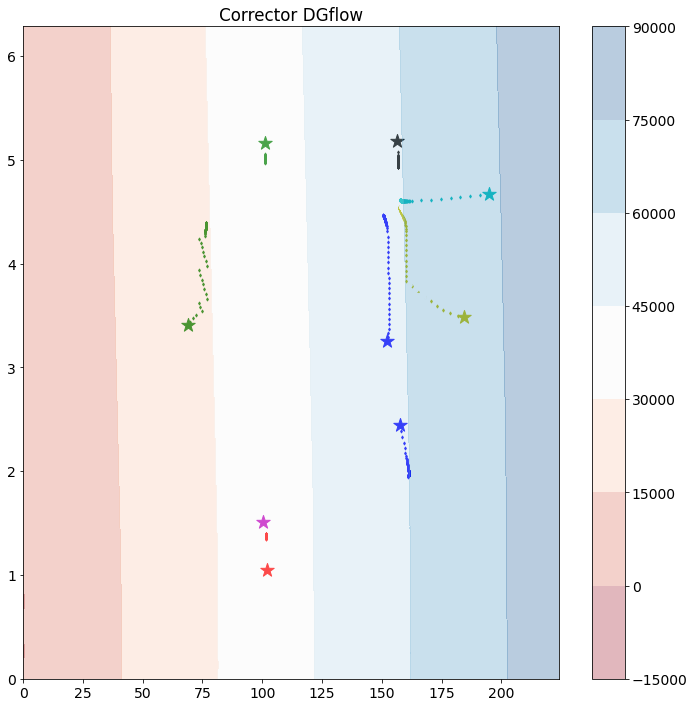

In [474]:
# colors = ['b','g','r','c','m','y','k','w']

fig, ax = plt.subplots(nrows=1, figsize=(12,12))
# ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')


# for i in range(real_data.size(0)):
for i in range(10):
    plt.scatter(real_data[i, 0]*224, real_data[i,1]*(2*3.14), marker='*', color=colors[i%8], s=200)
    for j in range(1, steps_refinement, 1):
        plt.scatter(all_x8[j][i, 0]*224, all_x8[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)
#         plt.scatter(all_xr[j][i, 0]*224, all_xr[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)






# Z, CS = draw_density_ratio(ax=ax,
#                    model=f,
# #                    model=f2,
# #                    p_type='log_density_ratio',
#                    p_type='p_y_given_x',
#                    device=device,
#                    x_lim=[0, 224],
#                    y_lim=[0, 2*np.pi],
#                    cmap='RdBu',
#                    step_size=0.05,
#                    Np=info2['neg_samples_size'], Nq=info2['pos_samples_size'])

Z, CS = draw_density_ratio2(ax=ax,
                   model1=f,
                   model2=f2,
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05,
                   Np1=info['neg_samples_size'],
                   Nq1=info['pos_samples_size'],
                   Np2=info2['neg_samples_size'],
                   Nq2=info2['pos_samples_size'])



# ax.set_title(f'Log density ratio')
ax.set_title(f'Corrector DGflow')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [16]:
item = load_item('fork')

In [17]:
# from matplotlib.patches import ArrowStyle
from matplotlib import animation
# arrow_style = ArrowStyle("Simple", head_length=.6, head_width=1.0, tail_width=.1)
from matplotlib.patches import Arrow

In [18]:
%matplotlib notebook

In [19]:
sample_stream = all_x8[1::2]

<IPython.core.display.Javascript object>


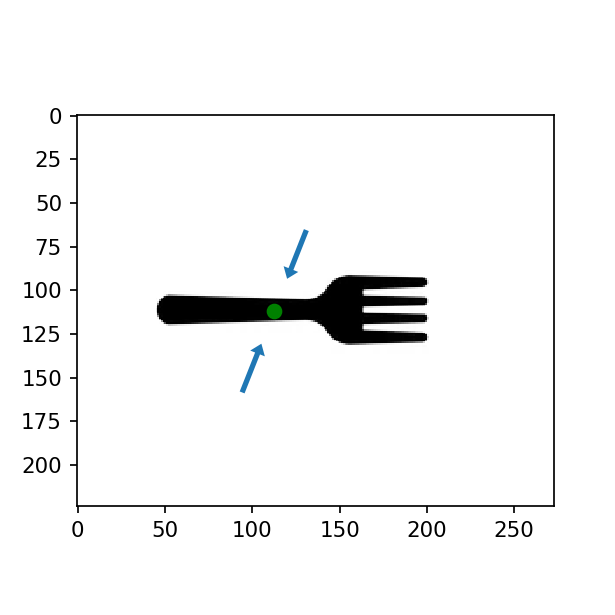

In [20]:
# def animate_grasp(sample_stream, fname):
fname = 'bad_to_pos_handle'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()

In [21]:
sample_stream = all_x8[::2]

<IPython.core.display.Javascript object>


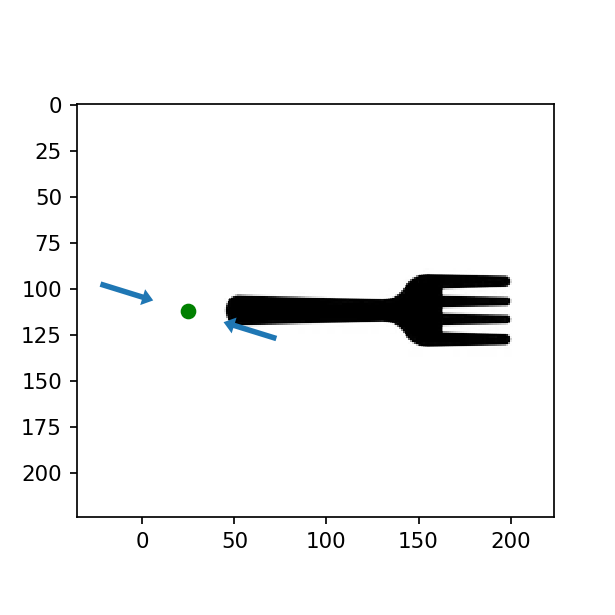

In [22]:
# def animate_grasp(sample_stream, fname):
fname = 'neg_to_pos'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()